In [ ]:
#default_exp Callbacks.SaveModel

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# SaveModel
> Learning to use the savemodel callback in fastaiv2

# Setup
Quickly setting up our fastai dataloader that we will use for training.

In [ ]:
#export
from fastai2.data.all import *
from fastai2.vision.all import *
from nbdev.showdoc import *

In [ ]:
#exports
path = untar_data(URLs.PETS)
path_anno, path_img = [path/folder for folder in path.ls()]

In [ ]:
#exports
pat = r'/(\w+)_\d+.jpg'

dblock = DataBlock((ImageBlock,CategoryBlock),
                    splitter=RandomSplitter(),
                    get_items=get_image_files,
                    item_tfms=Resize(224),
                    batch_tfms=aug_transforms(),
                    get_y=RegexLabeller(pat))

dls = dblock.dataloaders(path_img)

# SaveModel

To setup the savemodel callback all we have to do is import the class from callback.tracker. As we can see below in the documentation, we can set various parameters before adding it to our training.

In [ ]:
from fastai2.callback.tracker import SaveModelCallback

In [ ]:
#show_doc(SaveModelCallback)

<h2 id="SaveModelCallback" class="doc_header"><code>class</code> <code>SaveModelCallback</code><a href="https://github.com/fastai/fastai2/tree/master/fastai2/callback/tracker.py#L72" class="source_link" style="float:right">[source]</a></h2>

> <code>SaveModelCallback</code>(**`monitor`**=*`'valid_loss'`*, **`comp`**=*`None`*, **`min_delta`**=*`0.0`*, **`fname`**=*`'model'`*, **`every_epoch`**=*`False`*, **`add_save`**=*`None`*, **`with_opt`**=*`False`*) :: `TrackerCallback`

A `TrackerCallback` that saves the model's best during training and loads it at the end.

Before trying to use the callback, lets first explain the class parameters.

## Model compairison

* monitor: From the description above, this callback saves the "best" model during testing, but clearly this is a very fuzzy definition. Because of that we have the "monitor" variable, which tells us what we are compairing when choosing which model is better than the other.
* comp: Unlike monitor, "comp" defines HOW we compair the two models, instead of WHAT. By default it switches between np.greater and np.less functions depending on what we are monitoring. If you are changing monitor, it would be better to directly set comp as well.
* min_delta: Float value which gives us a delta for changing the "best" model. That way, we can get a newer model even if it's a tiny bit worse, in the value we are monitoring. This could be good when observing error or accuracy, so even if the error goes up, we still get the model with a better loss value which generalizes better.

## Saving Model

* fname: Name of the new model file. Should be changed constaintly and the changes should have parameters in the name to allow for easier model management.
* every_epoch: If set to True it will save every model trained and then load the best model at the end of training. If set to False it will only save the models that improve on the last best.
* add_save: If you want to save the model to a file you can add a path or "openable" object to write to. This is where the best model will be stored in. Not recommended when experimented since you lose precious experiments but can be better than every_epoch to true when looking to finalize a production model.
* with_opt: add optimizer state (gradients?) to the saved model. This would be ideal if you plan on training after reloading the model. Is not necessary if these are the final parameters.

Now that we understand how these work, we can test different combinations.

# Monitor

In [ ]:
#show
def train_with(monitor, fname, add_save=None, every_epoch=True, with_opt=True, epochs=4):
    cbs = (SaveModelCallback(monitor=monitor, fname=fname, add_save=add_save, every_epoch=every_epoch, with_opt=with_opt))
    learner = Learner(dls, resnet34(pretrained=True), metrics=error_rate)
    learner.fit_one_cycle(epochs, cbs=cbs)
    learner.show_results()
    torch.cuda.empty_cache()

epoch,train_loss,valid_loss,error_rate,time
0,1.661029,2.367526,0.551421,00:22
1,0.941002,1.335187,0.376861,00:21
2,0.502549,0.487209,0.156292,00:21
3,0.222762,0.349804,0.104195,00:21


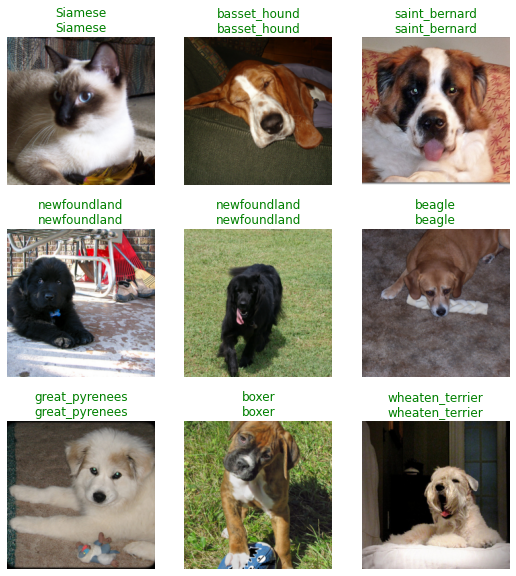

In [ ]:
#show
train_with("valid_loss", "valid_loss_save")

epoch,train_loss,valid_loss,error_rate,time
0,1.695786,2.011985,0.501353,00:21
1,0.948137,1.313558,0.368065,00:21
2,0.481372,0.461715,0.150880,00:21
3,0.240438,0.294652,0.089986,00:22


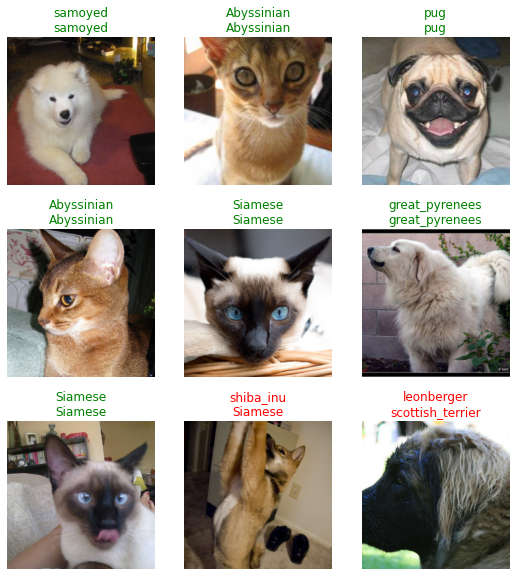

In [ ]:
train_with("error_rate", "error_rate_save")

epoch,train_loss,valid_loss,error_rate,time
0,1.668347,2.096309,0.487821,00:21
1,0.927796,1.105204,0.295670,00:21
2,0.510430,0.418985,0.129229,00:22
3,0.233746,0.300520,0.089310,00:21


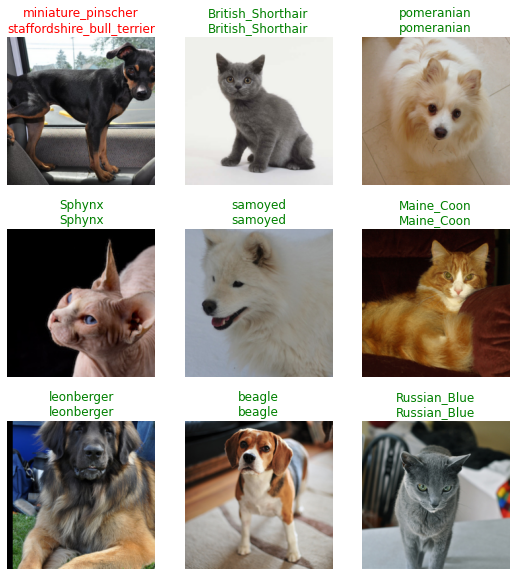

In [ ]:
save_file=Path("models/valid_loss_best.pth")
train_with("valid_loss", "valid_loss_only_best", add_save=save_file)

# Extended training

Most of the examples above just tests different metrics and floating point callback compatibility. Next we need to make sure that the training indeed chooses the best model. For this we need to "overfit" our model. 

epoch,train_loss,valid_loss,error_rate,time
0,1.897241,0.551634,0.152233,00:21
1,0.768208,1.028136,0.273342,00:21
2,0.857640,1.700849,0.448579,00:21
3,0.777479,1.361719,0.383627,00:22
4,0.747199,1.979853,0.444520,00:22
5,0.631593,0.935960,0.271989,00:22
6,0.550350,1.775895,0.408660,00:22
7,0.443266,1.408190,0.366712,00:22
8,0.348055,0.632054,0.177267,00:21
9,0.287428,0.741493,0.200947,00:22


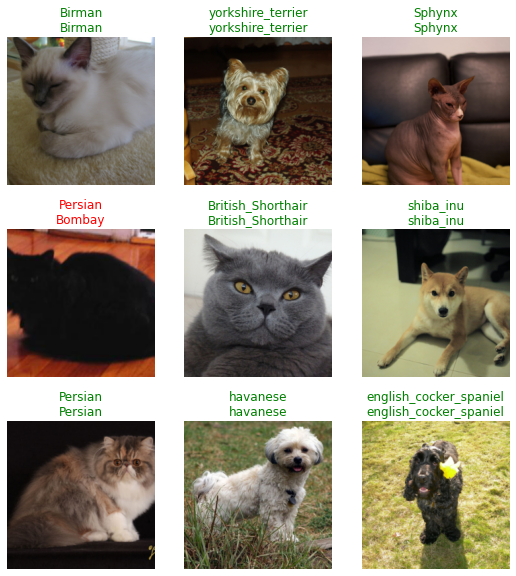

In [ ]:
save_file=Path("models/valid_loss_best_ext.pth")
train_with("valid_loss", "valid_loss_ext", add_save=save_file, every_epoch=False, epochs=16)

Although we weren't able to really overfit just yet (curse you fastai's well optimized hyperparameters!!!) we were still able to get the loss to go up. We verify this using `learner.validate()` above which runs the validation loop. Since this loop is not random we know that it belongs to epoch 13, not epoch 15.

But we still need to make sure that the saved model is in fact epoch 13, so we load the parameters and use validate again to see if it worked.

In [ ]:
learner = Learner(dls, resnet34(pretrained=True), metrics=error_rate)
learner.load("valid_loss_best_ext")

learner.validate()

(#2) [0.373029887676239,0.10284167528152466]

> Note: Remember when loading models that your seeds should be the same on all of the randomized data splitters

# Final Notes

Armed with this callback you can manage to get multiple tests in without having to constaintly check after each epoch. Also, because fit_one_cycle works differently based on how many epochs you use, you can still get the same training cycle while being able to revise the models after.

Since this is such an easy callback to add to any learner it would be best to ALWAYS do so, making sure to add the optimizer for a complete checkpoint of training.